In [51]:
#initialization
import random as rand
import numpy as np
import matplotlib.pyplot as plt

# importing Qiskit 
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister
from qiskit.circuit.library import DiagonalGate
from qiskit_aer import AerSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

In [52]:
# Oracle Gates from Better-than-classical paper
def oracle_00():
    circuit = QuantumCircuit(4)
    circuit.name = r'$\mathcal{O}_{00}$'

    circuit.id(0)
    circuit.x(1)
    circuit.x(2)
    circuit.id(3)

    for i in range(4):
        circuit.s(i)

    circuit.id(0)
    circuit.z(1)
    circuit.z(2)
    circuit.id(3)
    
    circuit.id(0)
    circuit.x(1)
    circuit.x(2)
    circuit.id(3)

    return circuit

def oracle_01():
    circuit = QuantumCircuit(4)
    circuit.name = r'$\mathcal{O}_{01}$'

    circuit.x(0)
    circuit.id(1)
    circuit.x(2)
    circuit.id(3)

    for i in range(4):
        circuit.s(i)

    circuit.id(0)
    circuit.z(1)
    circuit.z(2)
    circuit.id(3)
    
    circuit.x(0)
    circuit.id(1)
    circuit.x(2)
    circuit.id(3)

    return circuit

In [53]:
# [[4, 2, 2]] Encoding and Decoding functions

def encode():
    """
    Encode 2-qubits into [4, 2, 2] using a quantum circuit
    """
    circuit = QuantumCircuit(4)
    circuit.name = r'$\mathcal{U}_{\rm encode}$'

    circuit.h(0)

    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.cx(2, 3)

    return circuit

def decode():
    """
    Decode 2-qubits into [4, 2, 2] using a quantum circuit
    """
    circuit = QuantumCircuit(4)
    circuit.name = r'$\mathcal{U}_{\rm decode}$'

    circuit.cx(2, 3)
    circuit.cx(1, 2)
    circuit.cx(0, 1)

    circuit.h(0)
    
    return circuit

def stabilizer_1():
    """
    Stabilizer circuit for [4, 2, 2] code
    """
    circuit = QuantumCircuit(4)
    circuit.name = r'$\mathcal{S}_1$'

    for i in range(4):
        circuit.x(i)

    return circuit.to_gate().control(1)

def stabilizer_2():
    """
    Stabilizer circuit for [4, 2, 2] code
    """
    circuit = QuantumCircuit(4)
    circuit.name = r'$\mathcal{S}_2$'

    for i in range(4):
        circuit.z(i)

    return circuit.to_gate().control(1)

In [141]:
# Error functions
def x_error(probability, qubits=[0, 1, 2, 3]):
    """
    Insert X error at probability on qubits.
    Each qubit has a probability of getting an error.
    """
    circuit = QuantumCircuit(4)
    x_errors_on = []

    for i in qubits:
        if rand.random() < probability:
            circuit.x(i)
            x_errors_on.append(i)

    circuit.name = f'X Error\n{x_errors_on}'

    return circuit, x_errors_on

def z_error(probability, qubits=[0, 1, 2, 3]):
    """
    Insert Z error at probability on qubits.
    Each qubit has a probability of getting an error.
    """
    circuit = QuantumCircuit(4)
    z_errors_on = []

    for i in qubits:
        if rand.random() < probability:
            circuit.z(i)
            z_errors_on.append(i)

    circuit.name = f'Z Error\n{z_errors_on}'

    return circuit, z_errors_on

In [123]:
def grovers_algorithm(x_error_prob, z_error_prob):
    # Create the circuit
    circuit = QuantumCircuit()

    # Label registers for clarity
    circuit.add_register(QuantumRegister(1, 'qbit_1'))
    circuit.add_register(QuantumRegister(1, 'qbit_2'))
    circuit.add_register(QuantumRegister(1, 'qec_1'))
    circuit.add_register(QuantumRegister(1, 'qec_2'))
    circuit.add_register(QuantumRegister(1, 'stabilizer_1'))
    circuit.add_register(QuantumRegister(1, 'stabilizer_2'))
    circuit.add_register(ClassicalRegister(4, 'output'))
    circuit.add_register(ClassicalRegister(2, 'syndrome'))

    circuit.append(encode(), [0, 1, 2, 3])

    for i in range(4):
        circuit.h(i)

    circuit.barrier()

    # Oracle (01 Marked state)
    circuit.append(oracle_01(), [0, 1, 2, 3])
    circuit.barrier()

    for i in range(4):
        circuit.h(i)

    # Amplitude Amplification
    circuit.append(oracle_00(), [0, 1, 2, 3])
    for i in range(4):
        circuit.h(i)
    circuit.barrier()

    # Error insertion
    x_error_gate, x_errors_on = x_error(x_error_prob)[0], x_error(x_error_prob)[1]
    z_error_gate, z_errors_on = z_error(z_error_prob)[0], z_error(z_error_prob)[1]
    circuit.append(x_error_gate, [0, 1, 2, 3])
    circuit.append(z_error_gate, [0, 1, 2, 3])
    circuit.barrier()

    # Stabilizers
    circuit.h(4)
    circuit.append(stabilizer_1(), [4, 3, 2, 1, 0])
    circuit.h(4)

    circuit.h(5)
    circuit.append(stabilizer_2(), [5, 3, 2, 1, 0])
    circuit.h(5)

    circuit.measure(4, 4) # Qiskit reverses order of qubits
    circuit.measure(5, 5)

    circuit.barrier()

    # Decoding
    circuit.append(decode(), [0, 1, 2, 3])

    circuit.measure(0, 0)
    circuit.measure(1, 1)
    circuit.measure(2, 2)
    circuit.measure(3, 3)

    return circuit, x_errors_on, z_errors_on

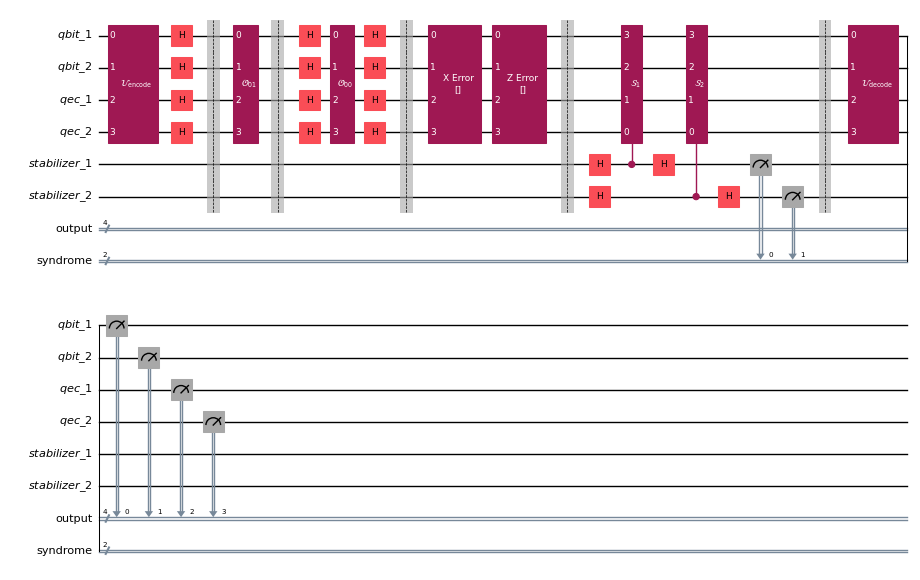

In [156]:
# Set probability for errors
x_error_prob = 0.0
z_error_prob = 0.0

# Create the circuit
grovers, x_errors, z_errors = grovers_algorithm(x_error_prob, z_error_prob)
grovers.draw('mpl', filename='grovers_circuit.png', scale=0.5)

In [157]:
valid_encodings = {
    '0000': '00',
    '0010': '01',
    '0111': '10',
    '0101': '11',
}

simulator = AerSimulator()
job_sim = transpile(grovers, simulator)
sim_result = simulator.run(job_sim, shots=1).result()
counts = sim_result.get_counts()
key = list(counts.keys())[0]
key = key.split(' ')

syndrome = key[0][::-1] # Qiskit outputs least significant
stabilizer_1_output = syndrome[0]
stabilizer_2_output = syndrome[1] # 1 = error, 0 = no error

print(f'X error probability: {x_error_prob}')
print(f'Z Error Probability: {z_error_prob}')
print(f'Actual X error on qubits {x_errors}')
print(f'Actual Z error on qubits {z_errors}')
print()

print(f'Syndrome: {syndrome}')
print(f'Stabilizer 1 output: {stabilizer_1_output}')
print(f'Stabilizer 2 output: {stabilizer_2_output}')
print()

output = key[1][::-1]
if output in valid_encodings:
    print(f'Grovers Algorithm output is valid: {output} -> {valid_encodings[output]}')
else:
    print(f'Grovers Algorithm output is invalid: {output}')

X error probability: 0.0
Z Error Probability: 0.0
Actual X error on qubits []
Actual Z error on qubits []

Syndrome: 00
Stabilizer 1 output: 0
Stabilizer 2 output: 0

Grovers Algorithm output is valid: 0010 -> 01
